# Data Exploration

In [313]:
import pandas as pd
import matplotlib
import numpy as np
matplotlib.style.use('fivethirtyeight')
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Load Data:

In [314]:
complete2014Data = pd.DataFrame.from_csv('cache/complete2014Data.csv')

### 1. Get Basic Information About Dataset

Infos such as size of data, number of flights per months, number of delays in total and average.

*A flight delay is a when an airline flight takes off and/or lands later than its scheduled time. The Federal Aviation Administration (FAA) considers a flight to be delayed when it is 15 minutes later than its scheduled time.*

Source: https://en.wikipedia.org/wiki/Flight_cancellation_and_delay

Percentage of flights with arrival delays and departure delays:

In [315]:
departureDelayed = complete2014Data.DEP_DELAY >= 15
arrivalDelayed = complete2014Data.ARR_DELAY >= 15
bothDelayed = (complete2014Data.DEP_DELAY >= 15) & (complete2014Data.ARR_DELAY >= 15)

print "Percentage departure delays out of all flights: ", sum(departureDelayed)/float(len(complete2014Data))
print "Percentage arrival delays out of all flights: ", sum(arrivalDelayed)/float(len(complete2014Data))
print "Arrival delayed if departure was already delayed: ", sum(bothDelayed)/float(sum(arrivalDelayed))

Percentage departure delays out of all flights:  0.205397048117
Percentage arrival delays out of all flights:  0.213156062972
Arrival delayed if departure was already delayed:  0.78331081604


As we can see above, roughly 1/5 of all flights have a delayed departure, almost the same percentage of flights arrives late at the destination. Only a small percentage of delayed departures manage to catch up during the flight, since more than 78% of the delayed arrivals already suffered from a delayed departure.

###2. What Airports are the Worst/Best?

Airport ranking (origin/destination) regarding delay times. For origin airports, we consider departure delay, and for destination airport we consider arrival delay.

Differentiate between different delay types (weather, security, etc.), e.g. are certain airports more affected by weather delays than others?

There are three modifications we make to the dataset in order to remove small entities with few data points, and to concentrate on actual delays:
 - Ignore airlines and airports with very few flights (using some threshold which we default to 365, representing one flight per day on average)
 - If delay is less than 0, representing an early departure, set the delay to 0 so it does not reduce the overall delay average.
 - Remove any entries in which the relevant delay value is null.

#### Best departure airport
Departure delay makes the most sense for determining delay of departure airports since the arrival delay is likely to have other factors outside the control of the departure airport. We use average delay as our metric in order to get a sense of the magnitude of delays, though we recognize there are other valid choices like percentage of delayed flights. As our results show, based on average departure delay, the best departure airports are:

 1. VEL (Vernal, UT)
 2. LWS (Lewiston, ID)
 3. CNY (Moab, UT)

In [316]:
threshold = 365 # Minimum number of flights per day

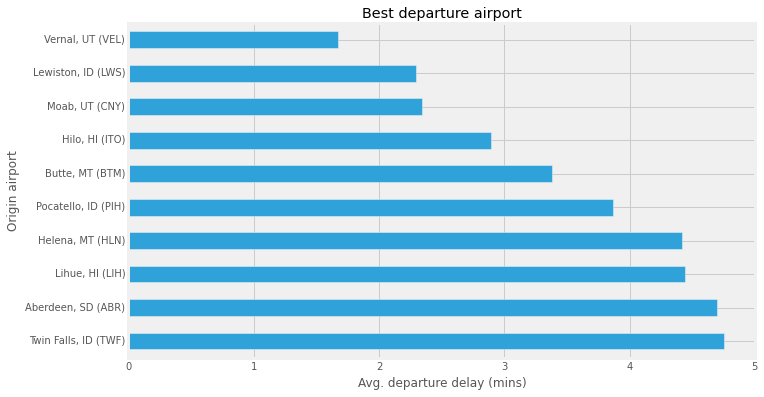

In [317]:
OADelay = complete2014Data[['ORIGIN', 'DEP_DELAY', 'ORIGIN_CITY_NAME']] 
OADelay = OADelay[OADelay.DEP_DELAY.notnull()] # Ignore entries with NaN values
OADelay.ix[(OADelay.DEP_DELAY < 0), 'DEP_DELAY'] = 0 # Don't consider early departures
OADelay['ORIGIN'] = OADelay['ORIGIN_CITY_NAME'] + ' (' + OADelay['ORIGIN'] + ')'

gbOA = OADelay.groupby('ORIGIN').agg(['mean', 'count'])
gbOA = gbOA[gbOA['DEP_DELAY']['count'] > threshold] # Select only origin airports with at least 1 flight per day

gbOA = gbOA.sort([('DEP_DELAY','mean')], ascending = True)
ax = gbOA.head(10)['DEP_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax.set_xlabel('Avg. departure delay (mins)')
ax.set_ylabel('Origin airport')
ax.set_title('Best departure airport')


#### Worst departure airport

Equivalently, the worst departure airports by average departure delay:
 1. CEC (Cresecent City, CA)
 2. EGE (Eagle, CO)
 3. ILG (Wilmington, DE)

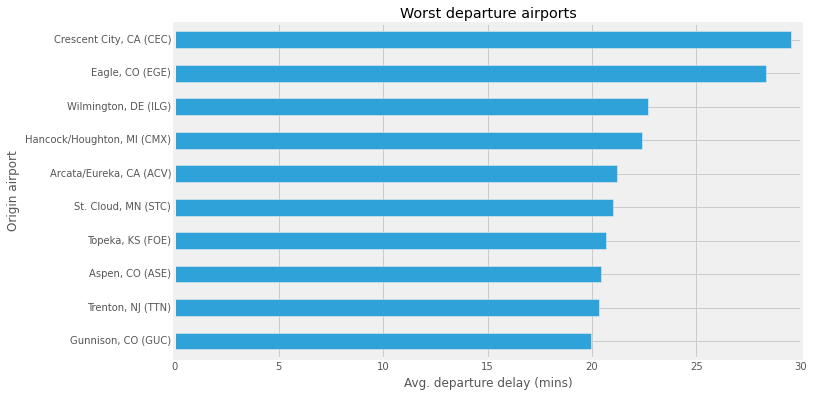

In [318]:
gbOA = gbOA.sort([('DEP_DELAY','mean')], ascending = False)
ax2 = gbOA.head(10)['DEP_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. departure delay (mins)')
ax2.set_ylabel('Origin airport')
ax2.set_title('Worst departure airports')

#### Best destination airport
Average arrival delay makes the most sense for determining delay of destination airports since the arrival delay is the total delay when reaching the destination airport. We use average delay as our metric in order to get a sense of the magnitude of delays, though we recognize there are other valid choices like percentage of delayed flights. As our results show, based on average arrival delay, the best destination airports are:


 1. LWS (Lewiston, ID)
 2. BTM (Butte, MT)
 3. VEL (Vernal, UT)

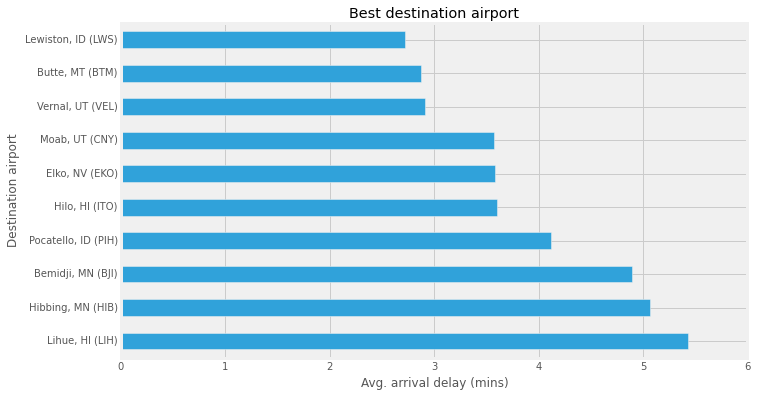

In [319]:
DADelay = complete2014Data[['DEST', 'ARR_DELAY', 'DEST_CITY_NAME']] 
DADelay = DADelay[DADelay.ARR_DELAY.notnull()] # Ignore entries with NaN values
DADelay.ix[(DADelay.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures
DADelay['DEST'] = DADelay['DEST_CITY_NAME'] + ' (' + DADelay['DEST'] + ')'

gbDA = DADelay.groupby('DEST').agg(['mean', 'count'])
gbDA = gbDA[gbDA['ARR_DELAY']['count'] > threshold] # Select only origin airports with at least 1 flight per day
gbDA = gbDA.sort([('ARR_DELAY','mean')], ascending = True)

ax = gbDA.head(10)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax.set_xlabel('Avg. arrival delay (mins)')
ax.set_ylabel('Destination airport')
ax.set_title('Best destination airport')

#### Worst destination airport

Equivalently, the worst destination airports by average arrival delay:
 1. FOE (Topeka, KS)
 2. ILG (Wilmington, DE)
 3. EGE (Eagle, CO)

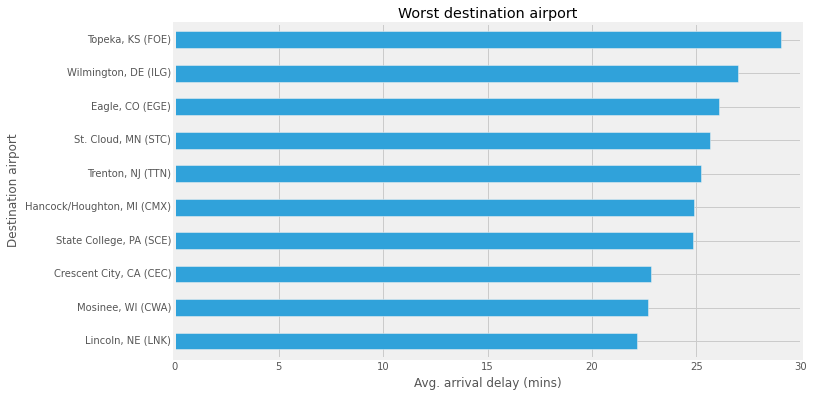

In [320]:
gbDA = gbDA.sort([('ARR_DELAY','mean')], ascending = False)
ax2 = gbDA.head(10)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Destination airport')
ax2.set_title('Worst destination airport')

###3. What Airlines are the Worst/Best? What About Specific Routes?

We identify the best and worst airlines to travel on when it comes to arrival delays. Again, we remove any entries with a null delay value, set negative delays to 0, and only consider airlines and routes with a certain threshold number of entries.

#### Best airlines

We use arrival delay here as, again, airlines will have an impact on delays throughout the course of the travel. Using average arrival delay, we find that the best airlines are:

 1. Hawaiian Airlines
 2. Alaska Airlines, Inc.
 3. Delta Air Lines


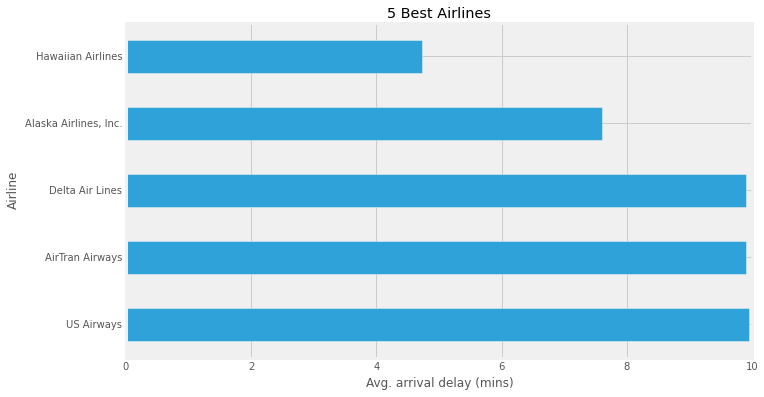

In [321]:
ANames = pd.read_csv('data/airline_names.csv')

AA = complete2014Data[['UNIQUE_CARRIER', 'ARR_DELAY']]
AA = pd.merge(AA, ANames, how='left', on='UNIQUE_CARRIER')
AA = AA[AA.ARR_DELAY.notnull()] # Ignore entries with NaN values
AA.ix[(AA.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures

AAgb = AA.groupby('UNIQUE_CARRIER').agg({'ARR_DELAY':['mean','count'], 'CARRIER_NAME': ['min']})
AAgb = AAgb[AAgb['ARR_DELAY']['count'] > threshold] # Select only airlines with at least 1 flight per day
AAgb = AAgb.sort([('ARR_DELAY','mean')], ascending = True)
AAgb = AAgb.set_index( ('CARRIER_NAME', 'min') )

ax2 = AAgb.head(5)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Airline')
ax2.set_title('5 Best Airlines')


#### Worst airlines

Equivalently, using average arrival delay, we find that the worst airlines are:

 1. ExpressJet
 2. Frontier Airlines
 3. American Eagle Airlines

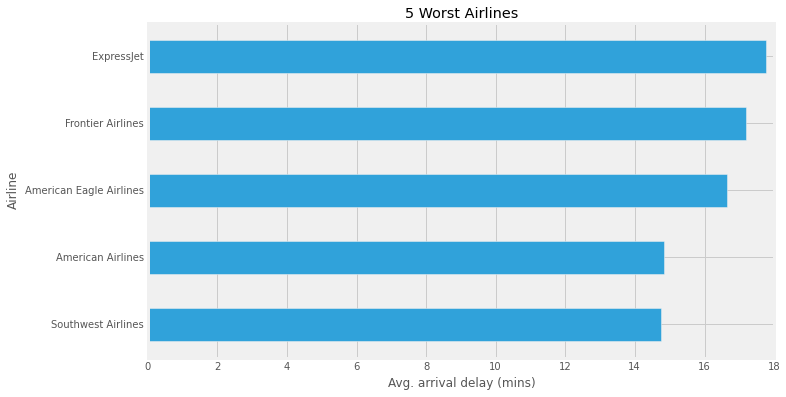

In [322]:
AAgb = AAgb.sort([('ARR_DELAY','mean')], ascending = False)
ax2 = AAgb.head(5)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Airline')
ax2.set_title('5 Worst Airlines')

#### Routes

We identify the best and worst routes to travel on when it comes to average arrival delays.

We find that the best routes to travel on are:
 1. Salt Lake City, UT (SLC) -> Moab, UT (CNY)
 2. Hilo, HI (ITO) -> Kahului, HI (OGG)
 3. Casper, WY (CPR) -> Salt Lake City, UT (SLC)
 
Notably, it seems that SLC airport (Salt Lake City, UT) features prominently among the best routes, both as an origin airport and a destination airport. 

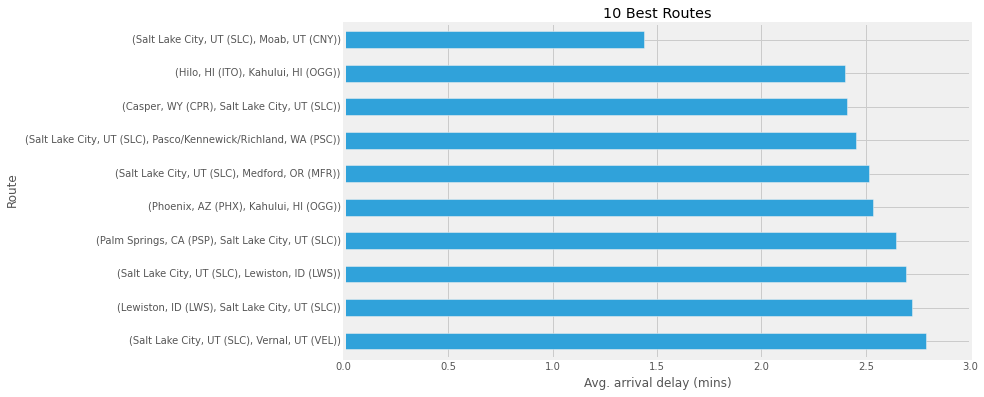

In [323]:
RA = complete2014Data[['UNIQUE_CARRIER', 'DEST', 'ORIGIN', 'ARR_DELAY', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME']]
RA = RA[RA.ARR_DELAY.notnull()] # Ignore entries with NaN values
RA.ix[(RA.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures
RA['ORIGIN'] = RA['ORIGIN_CITY_NAME'] + ' (' + RA['ORIGIN'] + ')'
RA['DEST'] = RA['DEST_CITY_NAME'] + ' (' + RA['DEST'] + ')'

RAgb = RA.groupby(['DEST', 'ORIGIN']).agg({'ARR_DELAY':['mean','count']})
RAgb = RAgb[RAgb['ARR_DELAY']['count'] > threshold] # Select only routes with a certain number of flights
RAgb = RAgb.sort([('ARR_DELAY','mean')], ascending = True)

ax2 = RAgb.head(10)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh') # Create the plot
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Route')
ax2.set_title('10 Best Routes')

#### Worst routes

We find that the worst routes to travel on are:
 1. Charlottesville, VA (CHO) -> Chicago, IL (ORD)
 2. San Francisco, CA (SFO) -> Crescent City, CA (CEC)
 3. Columbia, SC (CAE) -> Chicago, IL (ORD)
 
Notably, it seems that ORD airport (Chicago, IL) features prominently among the worst routes, both as an origin airport and a destination airport. 

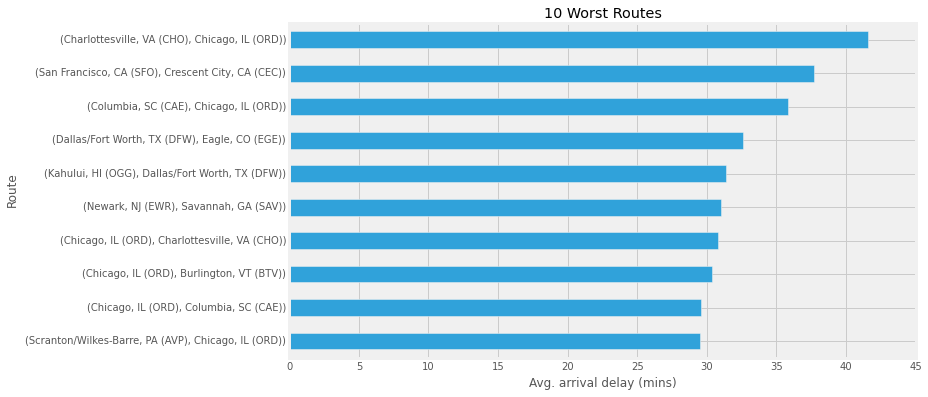

In [324]:
RAgb = RAgb.sort([('ARR_DELAY','mean')], ascending = False)

ax2 = RAgb.head(10)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Route')
ax2.set_title('10 Worst Routes')

### 4. Best times to travel

#### Best hour of the day
We wanted to find out if there were some hours of the day that were going to experience more delays. Intuitively it seemed that this would be true. In order to confirm this intuition, we plotted the arrival and departure delay across the hours of departure. As evident from the figure below, there is a consistent increase in delay from 5AM in the morning until around 7PM, before it drops off sharply. There also appears to be a smaller peak around 2AM as well.

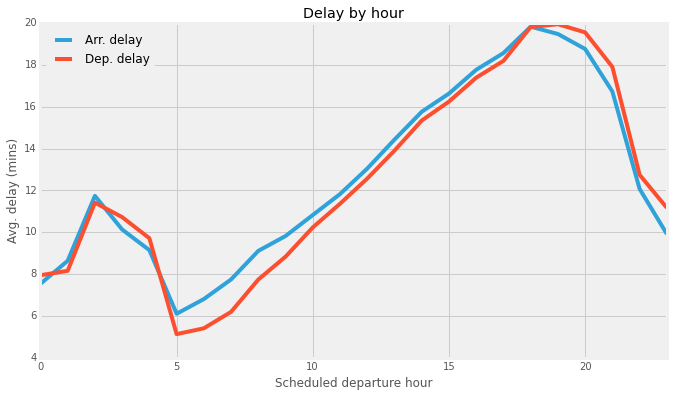

In [325]:
TA = complete2014Data[['CRS_DEP_TIME', 'ARR_DELAY', 'DEP_DELAY']]
TA = TA[TA.ARR_DELAY.notnull() & TA.DEP_DELAY.notnull()] # Ignore entries with NaN values
TA.ix[(TA.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures
TA.ix[(TA.DEP_DELAY < 0), 'DEP_DELAY'] = 0
TA.ix[:, 'CRS_DEP_HOUR'] = (TA['CRS_DEP_TIME'].astype(int) / 100).astype(int)

TAgb = TA.groupby('CRS_DEP_HOUR').agg({'ARR_DELAY':['mean','count'], 'DEP_DELAY':['mean','count']})
TAgb = TAgb[(TAgb[('ARR_DELAY', 'count')] > threshold) & (TAgb[('DEP_DELAY', 'count')] > threshold)]
ax = TAgb.reset_index().plot(kind='line', x='CRS_DEP_HOUR', y=('ARR_DELAY', 'mean'), label='Arr. delay')
ax = TAgb.reset_index().plot(kind='line', x='CRS_DEP_HOUR', y=('DEP_DELAY', 'mean'), label='Dep. delay', ax=ax)

ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Avg. delay (mins)')
ax.set_title('Delay by hour')


#### Best month of the year

Naturally, we might expect that some months are going to be busier for travelling than other months. Specifically, holiday season tends to experience more traffic, so delays are probably going to be more likely. As expected, from our analysis, we find that the months with the most delays are:
 1. January
 2. June
 3. February

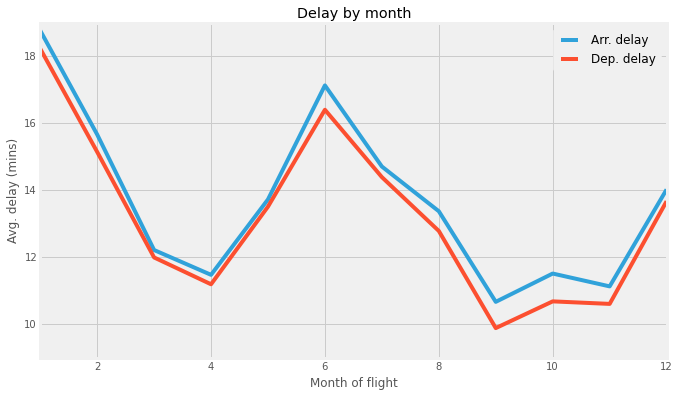

In [326]:
from datetime import datetime

def getMonth(datestring):
    dt = datetime.strptime(datestring, '%Y-%m-%d')
    return dt.month

MD = complete2014Data[['FL_DATE', 'ARR_DELAY', 'DEP_DELAY']]
MD = MD[MD.ARR_DELAY.notnull() & MD.DEP_DELAY.notnull()] # Ignore entries with NaN values
MD.ix[(MD.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures
MD.ix[(MD.DEP_DELAY < 0), 'DEP_DELAY'] = 0
MD.ix[:, 'MONTH'] = MD['FL_DATE'].apply(getMonth)

MDgb = MD.groupby('MONTH').agg({'ARR_DELAY':['mean','count'], 'DEP_DELAY':['mean','count']})
MDgb = MDgb[(MDgb[('ARR_DELAY', 'count')] > threshold) & (MDgb[('DEP_DELAY', 'count')] > threshold)]
ax = MDgb.reset_index().plot(kind='line', x='MONTH', y=('ARR_DELAY', 'mean'), label='Arr. delay')
ax = MDgb.reset_index().plot(kind='line', x='MONTH', y=('DEP_DELAY', 'mean'), label='Dep. delay', ax=ax)

ax.set_xlabel('Month of flight')
ax.set_ylabel('Avg. delay (mins)')
ax.set_title('Delay by month')

### 5. Special delays

In the dataset, there is a breakdown of the causes of different delays for certain entries. This breakdown is not present in all entries, and its absence is indicated by NaN values. Given the sparse nature of this additional information, for the analysis in this section, we focus only on the entries that have this data available, and exclude the rest. It turns out there are still a significant number of entries remaining.

Then, we consider the proportion of all delays for which the particular delay is greater than 0. The higher the percentage, the more often this factor is a cause in delays.

The different types of delays are described by the [Federal Aviation Administration](http://aspmhelp.faa.gov/index.php/Types_of_Delay). Here's the explanation they provide for the 3 special types of delay we look at here:

**Carrier Delay**
Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.

**Late Arrival Delay**
Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.

**Weather Delay**
Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.

#### Carrier delay
As this is largely caused by the carrier, we compare this delay to the different airlines. We find that airlines which contribute most to delays through carrier delays are:
 - Hawaiian Airlines
 - Southwest Airlines
 - JetBlue Airways
 
Note that Hawaiian Airlines is one of the best when it comes to average delay. This metric does not account for how often the plane is delayed; it only considers the proportion of instances where the carrier played a role in a delay. In other words, how blameworthy are the carriers when it turns out there is a delay? Can we attribute the delay to something out of their control (like weather)?

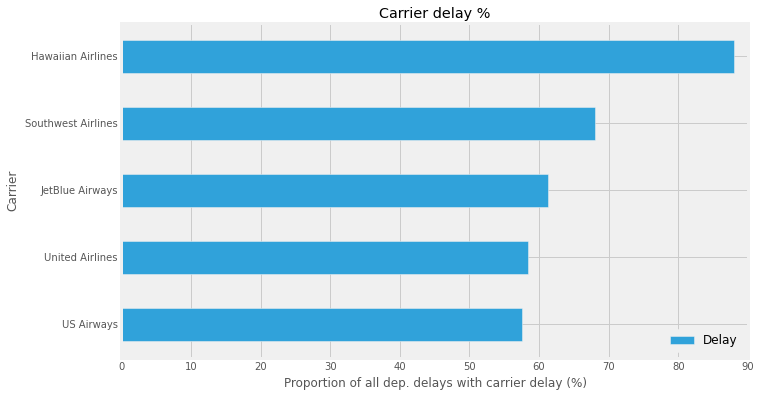

In [327]:
SD = complete2014Data[['UNIQUE_CARRIER', 'CARRIER_DELAY']]
SD = SD[SD.CARRIER_DELAY.notnull()]
SD['AT_FAULT'] = (SD.CARRIER_DELAY > 0) * 100
SD = pd.merge(SD, ANames, how='left', on='UNIQUE_CARRIER')

SD = SD.groupby('UNIQUE_CARRIER').agg( {'AT_FAULT':['count', 'mean'], 'CARRIER_NAME':'min'} )
SD = SD[ (SD['AT_FAULT']['count'] > 0) ] # Make sure flights are above threshold
SD = SD.sort(columns=('AT_FAULT', 'mean'), ascending=False)

ax = SD.head(5).reset_index().iloc[::-1].plot(y=('AT_FAULT', 'mean'), x=('CARRIER_NAME', 'min'), kind='barh', label='Delay')
ax.set_xlabel('Proportion of all dep. delays with carrier delay (%)')
ax.set_ylabel('Carrier')
ax.set_title('Carrier delay %')

#### Late aircraft delay
Again, this is largely caused by the carrier so we compare this delay to the different airlines. We find that airlines which contribute most to delays through late aircraft delays are:
 - Southwest Airlines
 - SkyWest Airlines
 - American Eagle Airlines
 
Turns out there has been some press around Southwest Airlines' aggressive scheduling. This has led to downstream delays as there is less buffer time between flights, increasing the instances of late aircraft delay.

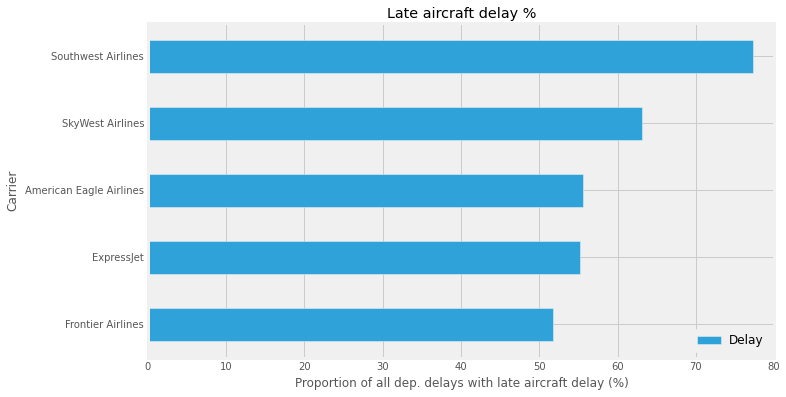

In [328]:
SD = complete2014Data[['UNIQUE_CARRIER', 'LATE_AIRCRAFT_DELAY']]
SD = SD[SD.LATE_AIRCRAFT_DELAY.notnull()]
SD['AT_FAULT'] = (SD.LATE_AIRCRAFT_DELAY > 0) * 100
SD = pd.merge(SD, ANames, how='left', on='UNIQUE_CARRIER')

SD = SD.groupby('UNIQUE_CARRIER').agg( {'AT_FAULT':['count', 'mean'], 'CARRIER_NAME':'min'} )
SD = SD[ (SD['AT_FAULT']['count'] > 0) ] # Make sure flights are above threshold

SD = SD.sort(columns=('AT_FAULT', 'mean'), ascending=False)

ax = SD.head(5).reset_index().iloc[::-1].plot(y=('AT_FAULT', 'mean'), x=('CARRIER_NAME', 'min'), kind='barh', label='Delay')
ax.set_xlabel('Proportion of all dep. delays with late aircraft delay (%)')
ax.set_ylabel('Carrier')
ax.set_title('Late aircraft delay %')

#### Weather delay
The intuition here is that some airports are located in areas that are more susceptible to difficult weather conditions for flying. We find that the airports which contribute most to delays through weather delays are:
 - Klamath Falls, OR (LMT)
 - Sault Ste. Marie, MI (CIU)
 - Deadhorse, AK (SCC)

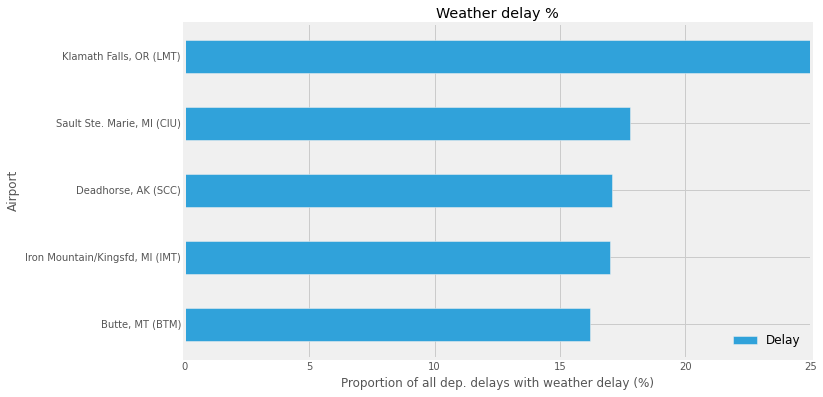

In [329]:
SD = complete2014Data[['ORIGIN', 'ORIGIN_CITY_NAME', 'WEATHER_DELAY']]
SD = SD[SD.WEATHER_DELAY.notnull()]
SD['AT_FAULT'] = (SD.WEATHER_DELAY > 0) * 100
SD['ORIGIN_CITY_NAME'] = SD['ORIGIN_CITY_NAME'] + ' (' + SD['ORIGIN'] + ')'

SD = SD.groupby('ORIGIN').agg( {'AT_FAULT':['count', 'mean'], 'ORIGIN_CITY_NAME':'min'} )
SD = SD[ (SD['AT_FAULT']['count'] > 0) ] # Make sure flights are above threshold
SD = SD.sort(columns=('AT_FAULT', 'mean'), ascending=False)

ax = SD.head(5).reset_index().iloc[::-1].plot(y=('AT_FAULT', 'mean'), x=('ORIGIN_CITY_NAME', 'min'), kind='barh', label='Delay')
ax.set_xlabel('Proportion of all dep. delays with weather delay (%)')
ax.set_ylabel('Airport')
ax.set_title('Weather delay %')